In [46]:
import os
import glob
import shutil
import pathlib
from itertools import chain
from functools import partial
from typing import Any, Callable, List, Literal, Optional, Tuple, Union

from PIL import Image

import numpy as np
import torch
from torchvision.datasets.utils import download_and_extract_archive
from torchvision.datasets import VisionDataset, Kitti


class KittiSTEP(VisionDataset):
    """`KITTI-STEP <https://www.cvlibs.net/datasets/kitti/eval_step.php>`_ Dataset.

    It corresponds to the "Segmenting and Tracking Every Pixel (STEP)" dataset, for video panoptic segmentation.
    Download link (https://huggingface.co/LXT/VideoK-Net/tree/main) from the authors of Video-K-Net (https://github.com/lxtGH/Video-K-Net)

    Args:
        root (string): Root directory where images are downloaded to.
            Expects the following folder structure if download=False:

            .. code::

                <root>
                    └── KittiSTEP
                        └─ video_sequence
                            ├── train
                            |   ├── 000000_000000_leftImg8bit.png
                            |   ├── 000000_000000_panoptic.png
                            |   ├── 000000_000001_leftImg8bit.png
                            |   ├── 000000_000001_panoptic.png
                            |   ├── ...
                            └── val
                            |   ├── ...
                            └── test
                                ├── ...

        mode ("train" | "val" | "test", optional): Use ``train`` split if "train", else ``val`` split if "val" else ``test`` split if "test".
            Defaults to ``train``.
        transform (callable, optional): A function/transform that takes in a PIL image
            and returns a transformed version. E.g, ``transforms.PILToTensor``
        target_transform (callable, optional): A function/transform that takes in the
            target and transforms it.
        transforms (callable, optional): A function/transform that takes input sample
            and its target as entry and returns a transformed version.
        download (bool, optional): If true, downloads the dataset from the internet and
            puts it in root directory. If dataset is already downloaded, it is not
            downloaded again.

    """

    data_url = "https://huggingface.co/LXT/VideoK-Net/resolve/main/"
    resources = [
        "kitti_step.zip",
    ]
    image_dir_name = ""
    annotation_dir_name = ""

    def __init__(
        self,
        root: str,
        mode: Literal["train", "val", "test"] = "train",
        frames_before: int = 0,
        transform: Optional[Callable] = None,
        target_transform: Optional[Callable] = None,
        transforms: Optional[Callable] = None,
        download: bool = False,
    ):
        super().__init__(
            root,
            transform=transform,
            target_transform=target_transform,
            transforms=transforms,
        )

        self.images = {}
        self.targets = {}
        self.root = root
        self.mode = mode
        self._location = self.mode
        self.frames_before = frames_before

        if download:
            self.download()
        if not self._check_exists():
            raise RuntimeError(
                "Dataset not found. You may use download=True to download it.")

        image_dir = os.path.join(
            self._raw_folder, self._location, self.image_dir_name)
        if self.mode:
            annotation_dir = os.path.join(
                self._raw_folder, self._location, self.annotation_dir_name)

        for img_file in glob.glob(os.path.join(image_dir, "*leftImg8bit*")):
            img_file = pathlib.Path(img_file).name

            splitted_filename = img_file.split('_')
            video_id, frame_id, _, ext = * \
                splitted_filename[:2], *splitted_filename[2].split('.')

            (
                self
                .images
                .setdefault(int(video_id), [])
                .append(os.path.join(image_dir, img_file))
            )

            if self.mode:
                (
                    self
                    .targets
                    .setdefault(int(video_id), [])
                    .append(os.path.join(annotation_dir, f"{video_id}_{frame_id}_panoptic.{ext}"))
                )

        self.index_mapping = list(map(
            # get video_id and frame_id from image path and build a tuple to use as index
            lambda x: tuple(map(int, pathlib.Path(x).name.split("_")[:2])),
            chain.from_iterable(self.images.values())
        ))

    def __getitem__(self, index: Union[int, Tuple[int, int]]) -> Tuple[Union[List[Any], Any], Union[List[Any], Any]]:
        """Get item at a given index.

        Args:
            index (int): Index
        Returns:
            tuple: (image, target), where
            target is the panoptic map of the image.

        """

        if isinstance(index, int):
            index = self.index_mapping[index]

        video_id, frame_id = index

        image = Image.open(self.images[video_id][frame_id])
        target = Image.open(self.targets[video_id][frame_id])

        # if self.frames_before:
        image_list = [image]
        target_list = [target]

        indices = list(range(frame_id - self.frames_before, frame_id))

        def get_frame_or_empty_image(data, example, frame_index):
            if frame_index < 0:
                return Image.new(example.mode, (example.width, example.height))
            return Image.open(data[video_id][frame_index])

        # append the reversed list of frames so that when reversed again, the frames are in the correct order
        image_list += list(map(partial(get_frame_or_empty_image,
                           self.images, image), indices))[::-1]
        target_list += list(map(partial(get_frame_or_empty_image,
                            self.targets, target), indices))[::-1]

        if self.transforms:
            # apply self.transform to each couple in the lists, then convert back to list
            transformed_images = []
            transformed_targets = []

            for img, target in zip(image_list, target_list):
                img = np.array(img)
                target = np.array(target)

                augmented = self.transforms(**{
                    'image': img,
                    'target': target,
                })
                transformed_images.append(augmented['image'])
                transformed_targets.append(augmented['target'])

            image_list = transformed_images
            target_list = transformed_targets

        if self.frames_before == 0:
            return image_list[0], target_list[0]

        return image_list[::-1], target_list[::-1]

    def __len__(self) -> int:
        return len(self.index_mapping)

    @property
    def _raw_folder(self) -> str:
        return os.path.join(self.root, "kitti_out", "video_sequence")

    def _check_exists(self) -> bool:
        """Check if the data directory exists."""
        folders = [self.image_dir_name]
        if self.mode:
            folders.append(self.annotation_dir_name)
        return all(os.path.isdir(os.path.join(self._raw_folder, self._location, fname)) for fname in folders)

    def download(self) -> None:
        """Download the KITTI data if it doesn't exist already."""

        if self._check_exists():
            return

        os.makedirs(self._raw_folder, exist_ok=True)

        # download files
        for fname in self.resources:
            download_and_extract_archive(
                url=f"{self.data_url}{fname}",
                download_root=self.root,
                filename=fname,
            )


In [103]:
import torch
from torchvision import transforms
import albumentations as A
from albumentations.pytorch import ToTensorV2

transform = A.Compose([
        A.ToFloat(max_value=255),
        A.CenterCrop(width=1224, height=370),
        A.HorizontalFlip(p=0.5),
        A.RandomBrightnessContrast(p=0.2),
        ToTensorV2()
    ],
    additional_targets={
        'target': 'image'
    }
)

ds = KittiSTEP(
    "/mnt/c/dev/repos/pix2seq/data/KittiSTEP",
    frames_before=5,
    mode="train",
    download=True,
    transforms=transform
)

trainloader = torch.utils.data.DataLoader(
    KittiSTEP(
        "/mnt/c/dev/repos/pix2seq/data/KittiSTEP",
        frames_before=5,
        mode="train",
        download=True,
        transforms=transform
    ),
    batch_size=16,
    shuffle=True,
    num_workers=4,
    pin_memory=True,
)

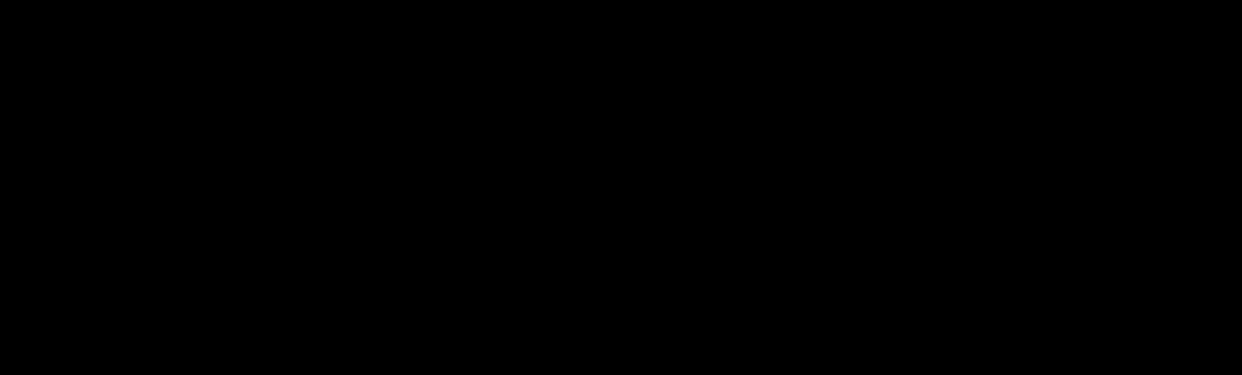

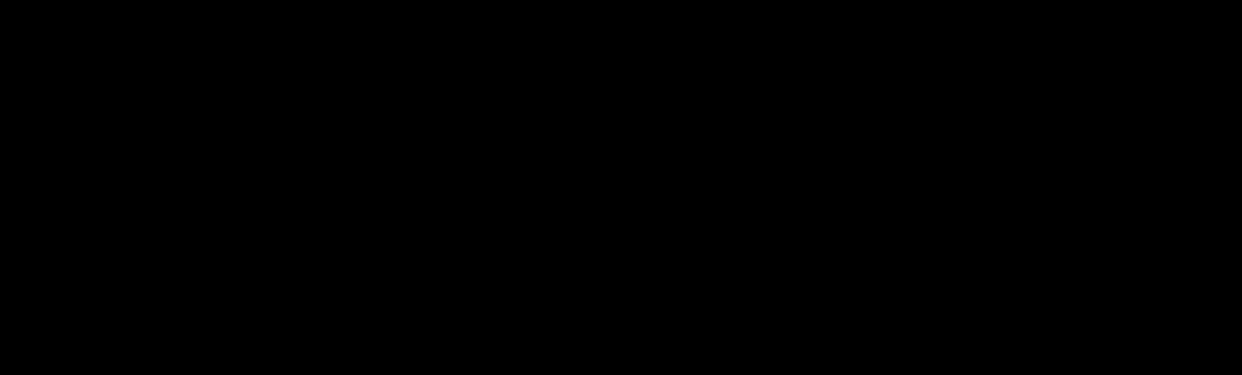

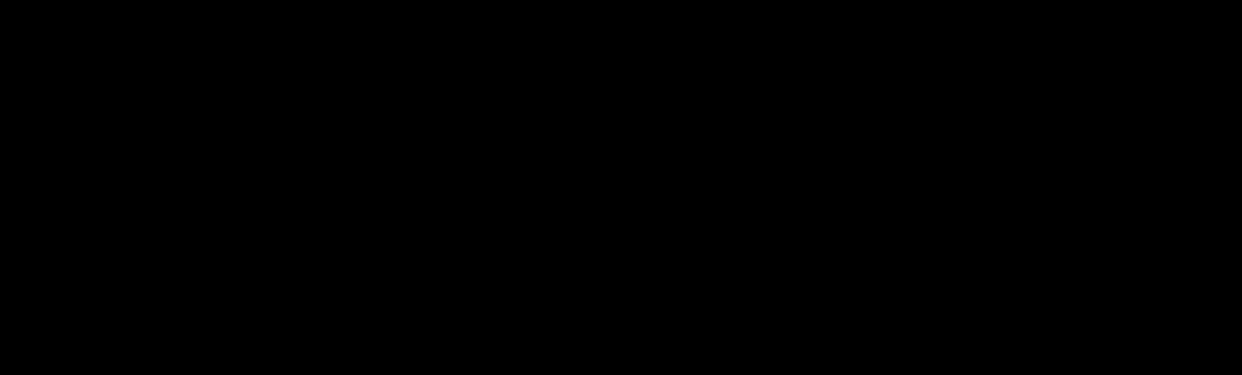

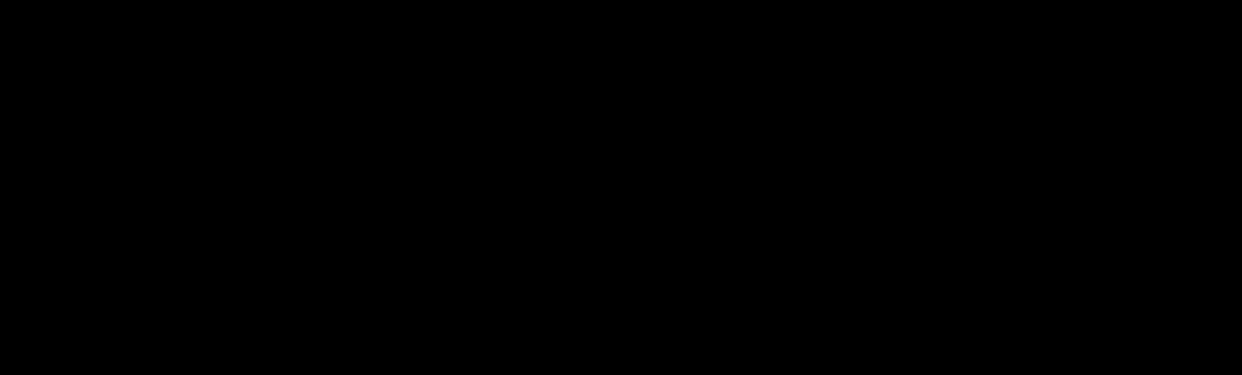

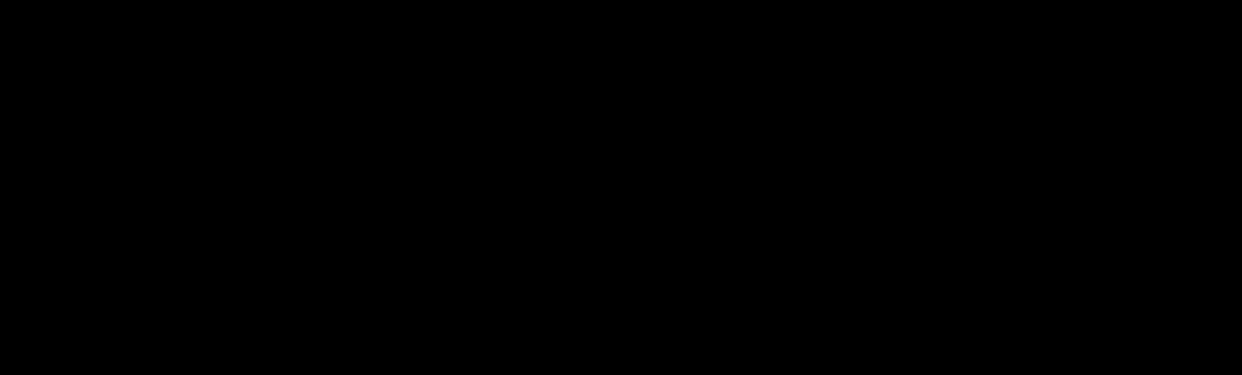

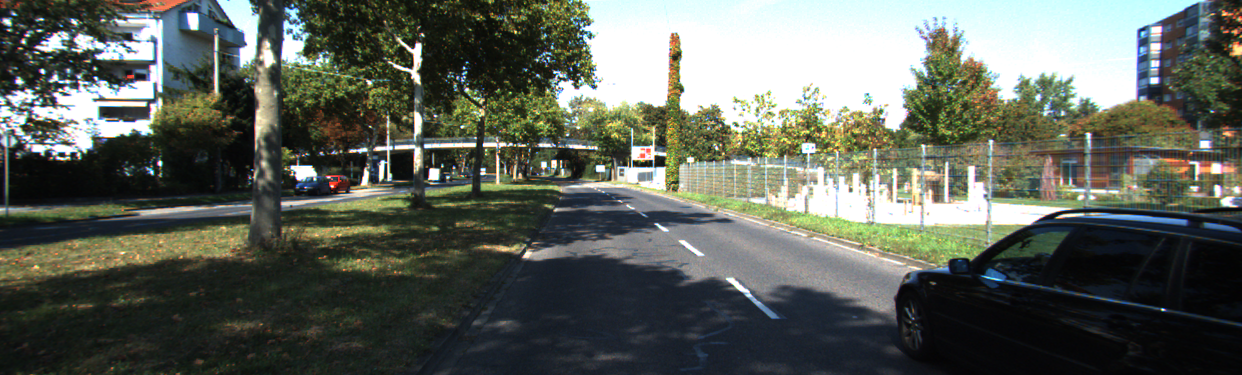

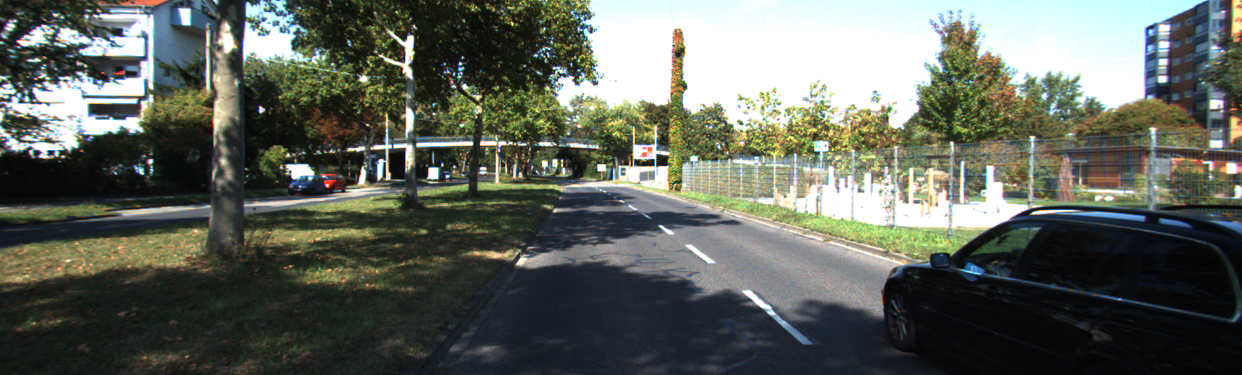

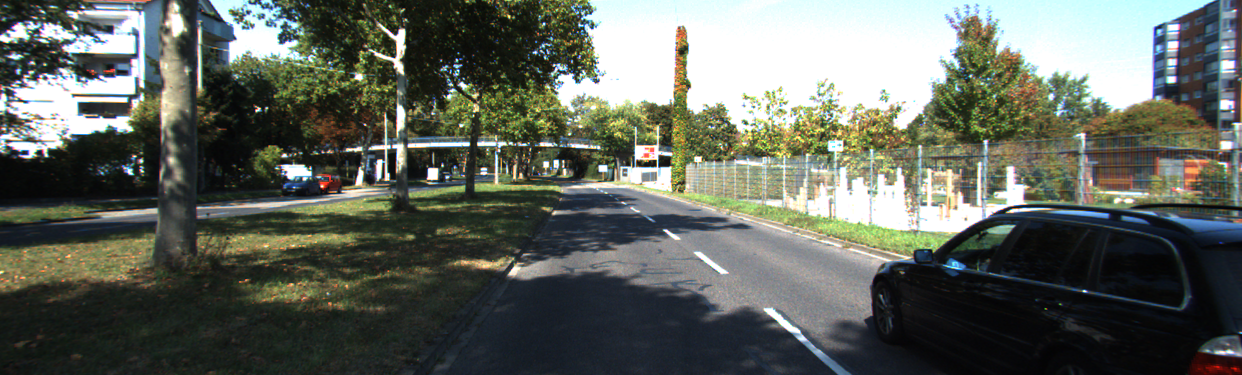

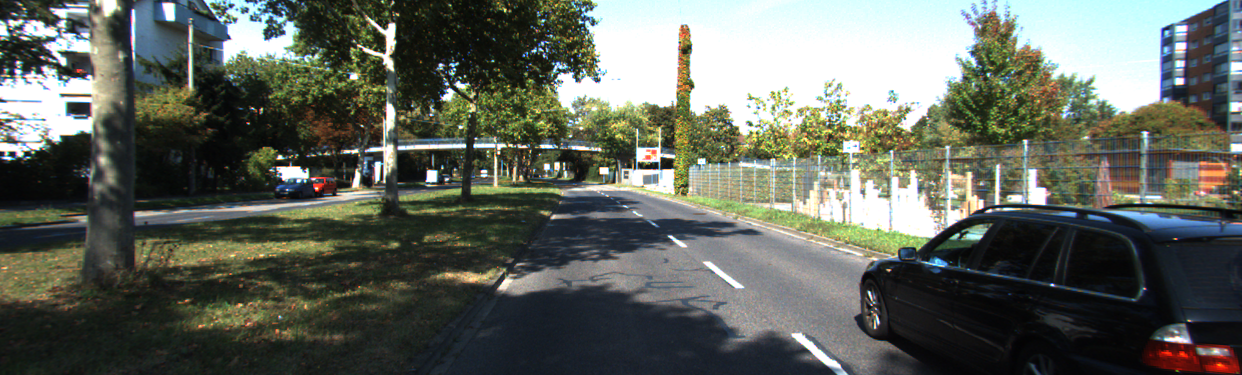

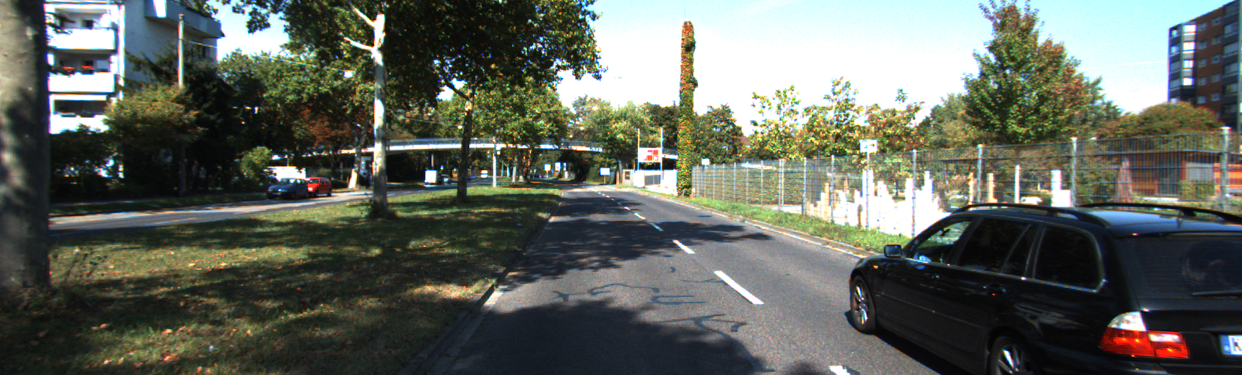

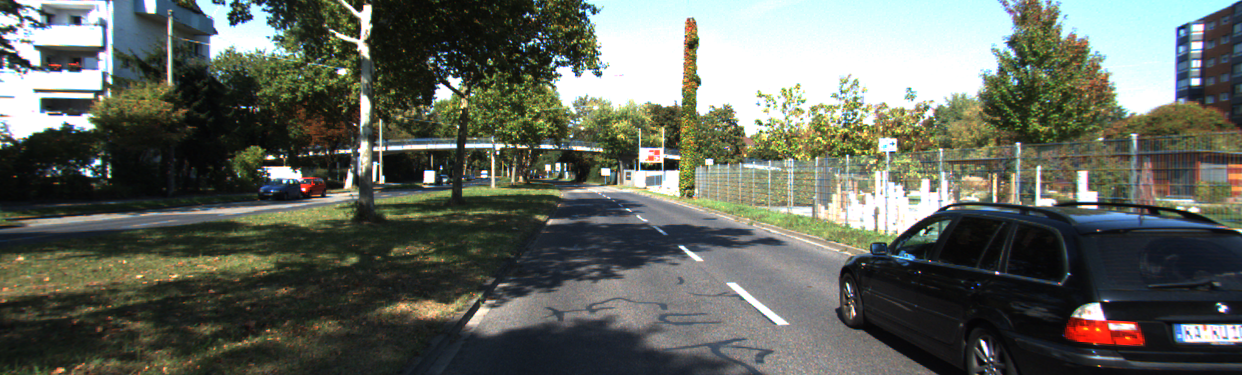

In [263]:
for img in ds[3, 5][0]:
    display(img)